> Vamos a hacer un análisis de como son en general las reviews respecto al tipo de cliente para ver si dejan diferencias según el segmento al que pertenecen y al genero de cada uno.

Vamos a importar los datos de reviews y customers, mergearlos y hacer un group by por segmento de cliente y resultados de reviews.

Si un cliente tiene más de una review, vamos a contar todas y sumar la cantidad de cada uno.

In [48]:
import pandas as pd

df_reviews = pd.read_pickle('../data/clean/reviews.pkl')

df_reviews = df_reviews[['customer_id', 'rating', 'is_verified_purchase']]
df_reviews

,customer_id,rating,is_verified_purchase
review_id,,,
1,473261,5,True
2,469672,4,True
3,416180,5,True
4,466834,4,True
5,490557,5,False
...,...,...,...
199996,423897,3,True
199997,462809,4,False
199998,498895,5,True


Solo vamos a considerar reviews de compras verificadas (is_verified_purchase = True).

In [49]:
verified_reviews = df_reviews[df_reviews['is_verified_purchase']]

verified_reviews = verified_reviews.drop(columns=['is_verified_purchase'])

verified_reviews.describe()

,customer_id,rating
count,159920.0,135911.0
mean,450125.966233,3.968744
std,28916.89553,1.022984
min,400009.0,1.0
25%,425078.0,4.0
50%,450179.0,4.0
75%,475162.0,5.0
max,500000.0,5.0


In [50]:
df_customers = pd.read_pickle('../data/clean/customers.pkl')

df_customers = df_customers[['customer_segment', 'gender']]

df_customers

,customer_segment,gender
customer_id,,
1,Regular,F
2,Budget,F
3,Budget,M
4,<NA>,M
5,Regular,M
...,...,...
499996,Premium,<NA>
499997,Regular,F
499998,<NA>,<NA>


In [51]:
reviews_with_customers = verified_reviews.merge(
    df_customers, left_on="customer_id", right_index=True, how="left"
)

reviews_by_segment_gender_and_rating = reviews_with_customers.groupby(
    ['customer_segment', 'gender', 'rating'], observed=False
).size().unstack(fill_value=0)

reviews_by_segment_gender_and_rating

rating                     1     2     3      4      5
customer_segment gender                               
Budget           F       300   747  1599   4312   3740
                 M       338   714  1563   4274   3754
Premium          F       329   737  1569   4359   3787
                 M       325   766  1669   4364   3795
Regular          F       959  2221  4866  12875  11262
                 M       985  2252  4813  13137  11172

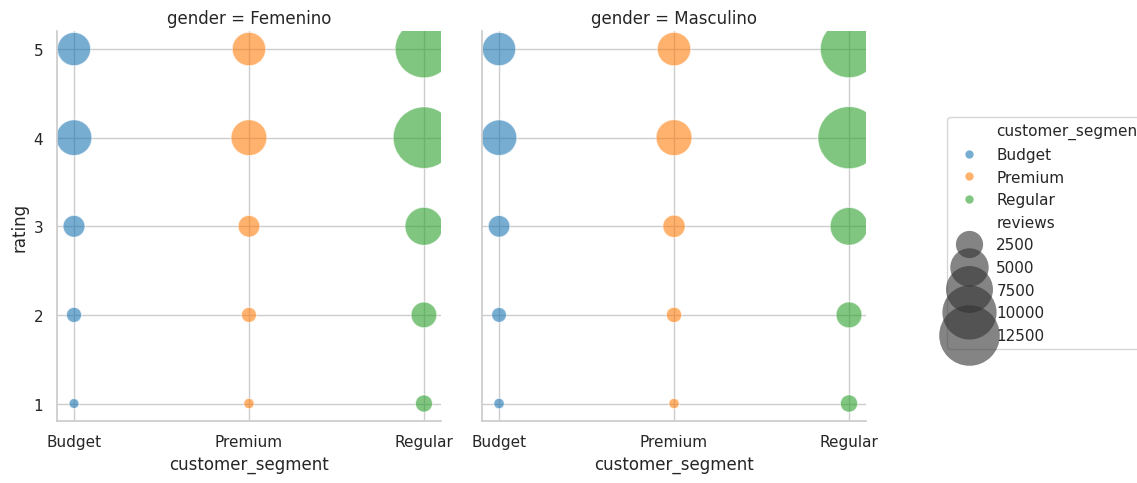

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="whitegrid")

df_long = reviews_by_segment_gender_and_rating.reset_index().melt(
    id_vars=["customer_segment", "gender"],
    value_vars=[1, 2, 3, 4, 5],
    var_name="rating",
    value_name="reviews",
)

# Etiquetas y órdenes
gender_map = {"F": "Femenino", "M": "Masculino"}
df_long["gender"] = df_long["gender"].map(gender_map)

seg_order = ["Budget", "Premium", "Regular"]
rating_order = ["5","4","3","2","1"]  # de 5 (arriba) a 1 (abajo)
df_long["rating"] = pd.Categorical(df_long["rating"].astype(str),
                                   categories=rating_order, ordered=True)

palette = sns.color_palette("tab10", n_colors=len(seg_order))

g = sns.relplot(
    data=df_long,
    x="customer_segment",
    y="rating",
    hue="customer_segment",
    hue_order=seg_order,
    size="reviews",
    sizes=(50, 2000),      
    alpha=0.6,
    col="gender",
    kind="scatter",
    height=5,
    aspect=0.9,
    palette=palette,
    legend=True,            
)


leg = g._legend
leg.set_bbox_to_anchor((1.05, 0.5))
leg.set_frame_on(True)

plt.show()

Como vemos no hay prácticamente diferencias entre los géneros pero si entre los segmentos donde los clientes "Regulares" son los que más reviews dejan. Esto es probablemente porque los regulares son los que más hay en la plataforma como ya vimos en [aquí](03_segmentos_tipo_de_pago.ipynb).

> PD: Perdón por los circulos nos los pude arreglar

Habría que validar con un stacked chart si hay diferencias en las proporciones de ratings según el segmento.

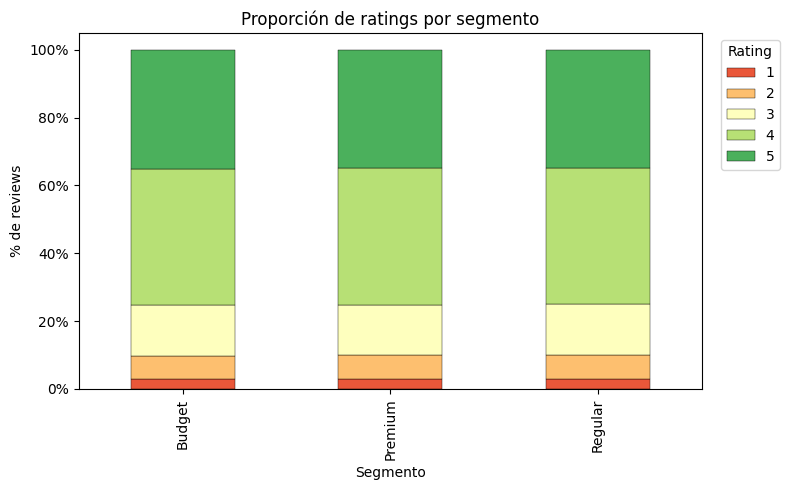

In [63]:
# Stacked 100% por segmento (proporciones de ratings)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

rating_order = [1, 2, 3, 4, 5]

counts = reviews_by_segment_gender_and_rating.groupby(level='customer_segment').sum()
counts = counts.reindex(columns=rating_order, fill_value=0)
props = counts.div(counts.sum(axis=1), axis=0)

ax = props.plot(kind='bar', stacked=True,
                color=sns.color_palette("RdYlGn", len(rating_order)),
                edgecolor='black', linewidth=0.3, figsize=(8, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Segmento")
ax.set_ylabel("% de reviews")
ax.set_title("Proporción de ratings por segmento")
ax.legend(title="Rating", labels=rating_order, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Como vemos no hay una variación de la puntuación de las reviews en función del segmento del cliente.